# ALENN - Demo Notebook
## Quickstart Guide

Donovan Platt
<br>
Mathematical Institute, University of Oxford
<br>
Institute for New Economic Thinking at the Oxford Martin School
<br>
<br>
Copyright (c) 2020, University of Oxford. All rights reserved.
<br>
Distributed under a BSD 3-Clause licence. See the accompanying LICENCE file for further details.

# Overview
This notebook provides, through the use of a simple illustrative example, a complete tutorial on the use of the ALENN package to perform Bayesian estimation for economic simulation models using the neural network-based approach introduced by Platt (2021) in the paper *[Bayesian Estimation of Economic Simulation Models Using Neural Networks](https://link.springer.com/article/10.1007/s10614-021-10095-9)*. In general, the workflow presented here should require minimal adjustment (changing the model function, empirical dataset, priors, and sampler settings) in order to be applied to new examples.

# Step 1
## Importing of Packages
As a natural starting point, we begin by importing any required Python packages. With the exception of ALENN, which we assume has already been installed as per the instructions provided in the accompanying README file, all other imported libraries are now fairly standard in most data science workflows.

In [1]:
# Import the ALENN ABM Estimation Package
import alenn

# Import Plotting Libraries
import matplotlib.pyplot as plt

# Import Numerical Computation Libraries
import numpy as np
import pandas as pd

# Import General Mathematical Libraries
from scipy import stats

# Import Data Storage Libraries
import pickle as pkl

# Import System Libraries
import os
import logging

Using TensorFlow backend.


In [2]:
# Disable Tensorflow Deprecation Warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Tensorflow 2.x deprecates many Tensorflow 1.x methods, causing Tensorflow 1.15.0 to output a large number 
# of (harmless) deprecation warnings when performing the first likelihood calculation. This can be very 
# distracting, leading us to disable them.

# Step 2
## Creating the Likelihood and Posterior Estimator Object
The primary functionally of ALENN is implemented in the `MDNPosterior` class, which contains all the methods required to estimate the likelihood and posterior. It thus follows that the first step in the estimation pipeline is creating an `MDNPosterior` object by calling its constructor method, `alenn.mdn.MDNPosterior`.
<br>
<br>
If no arguments are provided to the constructor, the default neural network architecture introduced in the paper is used. If an alternative is required, however, this can easily be specified through the use of keyword arguments. As an example, increasing the number of lags to 4 and decreasing the number of hidden layers to 2 could be achieved by calling `alenn.mdn.MDNPosterior(num_lags = 4, num_layers = 2)`. Further details can be obtained by consulting the class docstring: 
```python
?alenn.mdn.MDNPosterior
```

In [3]:
# Create an MDN Posterior Approximator Object (Uses Default Settings from the Paper)
posterior = alenn.mdn.MDNPosterior()

--------------------------------------
Successfully created a new MDN object:
--------------------------------------
Number of lags:                3                   
Number of mixture components:  16                  
Number of neurons per layer:   32                  
Number of hidden layers:       3                   
Batch size:                    512                 
Number of epochs:              12                  
Activation function:           relu                
Input noise:                   0.2                 
Output noise:                  0.2                 
--------------------------------------



# Step 3
## Specifying the Candidate Model
At this stage, all we have done is defined a generic posterior estimator object. In order to actually apply the estimator to a given problem, we need to provide the object with additional information. We begin with the candidate model.
<br>
<br>
From the perspective of ALENN, the model is a black box capable of producing simulated time series data. Therefore, the candidate model is provided to ALENN in the form of a function that takes in a 1-d numpy array or list of parameter values and returns a model output matrix as a 2-d numpy array. Ensuring that the model is correctly specified and matches ALENN's input, processing, and output requirements is perhaps the most critical part of this process and should therefore be approached with care.
<br>
<br>
To elaborate, the model function should take, as input, a 1-d numpy array, $\mathbf{\theta}$, containing values for each of the model's free parameters (those that should be estimated). The function should then proceed to generate a corresponding set of $R$ model Monte Carlo replications. Each of these replications is a single time series of length $T_{sim}$ generated by the model for the same set of parameter values as the remaining replications, $\mathbf{\theta}$, but a different random seed, $i$. Once generated, each replication should be stored as a single column in a $T_{sim} \times R$ numpy array that is returned as the final output by the model function.
<br>
<br>
It is important to note that, although the choice of seed for each replication is arbitrary, the same set of seeds must be used throughout the entire estimation experiment, i.e. the model function should always use the same set of seeds, regardless of the value of $\mathbf{\theta}$ at which the function is evaluated. Footnote 44 in the paper provides a more detailed discussion. Additionally, in most practical examples, the generation of simulated data using the candidate model is likely to be computationally-expensive and thus a bottleneck in the inference process. We therefore suggest that, if the model is costly to simulate, that the model function should generate the replications in parallel.
<br>
<br>
Finally, as suggested by the model function output structure introduced above, this version of ALENN currently only supports univariate time series model outputs. Note, however, that the methodology itself is generally applicable to multivariate outputs and a multivariate extension to this library is likely to be released in the near future.

In [4]:
# Specify the Simulated Data Characteristics
T_sim = 1000    # Length of each Monte Carlo replication
R = 100         # Number of Monte Carlo replications
seed_set = 7    # The set of seeds associated with the model replications

# In most cases, we suggest that either (T_sim = 1000 and R = 100) or (T_sim = 2000 and R = 50) be considered.
# The seed_set variable can be interpreted as defining an arbitrary set of 100 random seeds.

# Define the Candidate Model Function
def model(theta):
    return np.diff(alenn.models.random_walk(700, 0.4, 0.5, theta[0], theta[1], T_sim, R, seed_set), axis = 0)

# Add the Model Function to the MDNPosterior Object
posterior.set_model(model)

# In the above, we have selected the random walk examined in the paper's comparative experiments. This model, 
# along with the other models considered in the paper, are implemented as part of ALENN and can be accessed via
# alenn.models as above (see the corresponding file for more details). 
#
# In this case, we are attempting to estimate the pre- and post-break volatility and have fixed all other parameters 
# to their default values. Notice that we also consider the series of first differences to induce stationarity. 
# While stationarity is not an assumption of the methodology, it may be advantageous to consider stationarity 
# transformations if a given non-stationary model proves to be difficult to estimate.

Model function successfully set.
----------------------------------------------------------------------------



# Step 4
## Specifying the Model Priors
As in any Bayesian exercise, we must specify a prior over the model parameters. In ALENN, the prior is specified
in the form of a special data structure. A prior function must be defined separately for each free parameter and each function of this type should take in a single value for that parameter and return a corresponding prior density value. These functions should be stored in a Python list.
<br>
<br>
In all cases, the order of the density functions in the prior list must correspond to the order in which the parameters are passed to the model function. More concretely, if the model function takes in values for parameters $[\sigma_1, \sigma_2]$, the prior list must have form $[p(\sigma_1), p(\sigma_2)]$.

In [5]:
# Define Parameter Priors
priors = [stats.uniform(loc = 0, scale = 10).pdf,
          stats.uniform(loc = 0, scale = 10).pdf]

# Add the Model Priors to the MDNPosterior Object
posterior.set_prior(priors)

# In the above, we have defined uniform priors over [0, 10] for both the pre- and post-break volatility. In most 
# applications, we recommend that users make use of SciPy's stats module to define the priors, as we have. This 
# results in greater readability and can help avoid errors in the prior specification.

Model prior successfully set. The model has 2 free parameters.
----------------------------------------------------------------------------



# Step 5
## Loading the Empirical Data
To complete the problem specification, we are finally required to provide the `MDNPosterior` object with a set of empirical data. This process is rather straightforward and simply requires that the data be provided in the form of a 1-d numpy array.
<br>
<br>
While longer empirical time series are always preferred if available, we typically consider $T_{emp} = 1000$ for problems involving $1-4$ free parameters and $T_{emp} = 2000$ for problems involving $5-10$ free parameters. In many cases, however, we suspect that a significant reduction in the number of data points would be viable, particularly when the data provides a reasonable level of information regarding the model parameters.

In [6]:
# Load the Empirical Data
with open('data/Demo_Data', 'rb') as f:
    empirical = pkl.load(f)

# Add the Empirical Data to the MDNPosterior Object
posterior.load_data(empirical)

# The empirical data loaded above is a synthetic series of 999 (first-differenced) observations generated by the
# random walk model when initialised using the parameter values associated with the first free parameter set 
# introduced in the paper's comparative exercises. Our exercise here can thus be seen as a replication of the
# associated comparative experiment.
#
# In a true empirical application, this series would simply be replaced by a series measured from the actual
# real-world system being modelled.

Empirical data successfully loaded. There are 999 observations in total.
----------------------------------------------------------------------------



# Step 6
## Sampling the Posterior
With the `MDNPosterior` object now completely specified, we are able to evaluate the posterior for arbitrary values of $\mathbf{\theta}$ and hence sample it using MCMC. As discussed in detail in Appendix 2, we make use of the adaptive Metropolis-Hastings algorithm proposed by Griffin and Walker (2013).
<br>
<br>
As in the case of the posterior, the sampler is also implemented as an object, in this case being an instantiation of the `AdaptiveMCMC` class. In order to perform the sampling procedure, a number of key components must be specified and passed to the object. These include:
* Parameter ranges over which to conduct the initial sweep of the parameter space. This is specified in the form of two 1-d numpy arrays that contain, in the same order as is associated with the list of priors discussed in Step 4, the lower and upper bounds for each parameter respectively.
* The desired number of samples per sample set. In general, we recommend that this is set to $K = 70$.
* The desired number of sample sets to be generated. As a rule of thumb, we suggest generating $S = 5000$ sets for problems involving $1 - 4$ free parameters and $15000$ sets for problems involving $5 - 10$ free parameters. Of course, common convergence diagnostics, such as Galman and Ruben's R, could certainly be used to ensure that a sufficient number of samples has been generated.

In [52]:
# Create an Adaptive MCMC Sampler Object
sampler = alenn.mcmc.AdaptiveMCMC(K = 70, S = 5000)

# Define the Parameter Bounds
theta_lower = np.array([0, 0])
theta_upper = np.array([10, 10])

# Add the Posterior Approximator and Parameter Ranges to the Newly-created Object
sampler.set_posterior(posterior)
sampler.set_initialisation_ranges(theta_lower, theta_upper)

# Please note that the set_posterior method must be called before the set_initialisation_ranges method.

# Initiate the Sampling Process
sampler.sample_posterior()

-----------------------------------------------
Successfully created a new MCMC sampler object:
-----------------------------------------------
Number of sample sets:         5000                
Number of samples per set:     70                  
-----------------------------------------------

MDNPosterior object successfully loaded.
----------------------------------------------------------------------------

Initialisation ranges successfully set.

           Lower Bound  Upper Bound
Parameter                          
1                    0           10
2                    0           10
----------------------------------------------------------------------------



# Step 7
## Processing the Obtained Samples
Once the sampling procedure has concluded, all that remains is the processing of the obtained samples into meaningful outputs, i.e. tables or marginal posterior plots.
<br>
<br>
The aforementioned samples may be extracted from the `AdaptiveMCMC` object using the `process_samples` method, which requires the specification of a single integer argument, `burn_in`. This argument specifies the number of sample sets that should be discarded as part of an initial burning-in period, as is standard in all MCMC algorithms, and we typically recommend burning-in periods of $1500-2500$ sample sets for $S = 5000$ and $7500-10000$ sample sets for $S = 15000$. Of course, some problems may require alternative configurations depending on their associated convergence rates and we therefore recommend that multiple chains be generated by repeating Step 6 several times in order to diagnose convergence when applying the methodology.
<br>
<br>
The `process_samples` method returns the obtained samples in the form of a 2-d numpy array, where each column represents the posterior samples obtained for a given parameter, with the columns following the same parameter order as the original model function. The method output also contains a final, extra column consisting of the the associated log-likelihood samples.

In [48]:
# Result Table

# Note that we illustrate the construction of a result table for a single chain, whereas the corresponding result
# in Section 4.1 is associated with 5 chains.

# Process the Sampler Output
samples = sampler.process_samples(burn_in = 2500)

# Calculate the Posterior Mean
pos_mean = samples[:, :posterior.num_param].mean(axis = 0)

# Calculate the Posterior Standard Deviation
pos_std = samples[:, :posterior.num_param].std(axis = 0)

# Construct a Result Table
result_table = pd.DataFrame(np.array([pos_mean, pos_std]).transpose(), columns = ['Posterior Mean', 'Posterior Std. Dev.'])
result_table.index.name = 'Parameter'
result_table.index += 1

# Display the Result Table
print('Final Estimation Results:')
print('')
print(result_table)

Final Estimation Results:

           Posterior Mean  Posterior Std. Dev.
Parameter                                     
1                0.946465             0.032059
2                1.951355             0.102465


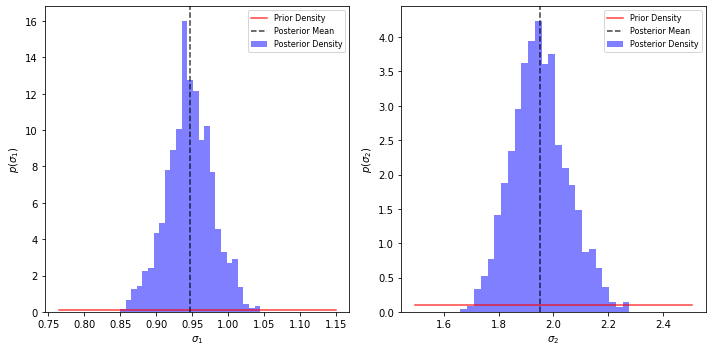

In [51]:
# Marginal Posterior Plots

# Note that we illustrate the construction of marginal posterior plots for a single chain, whereas the corresponding 
# result in Section 4.1 is associated with 5 chains.

# Process the Sampler Output
samples = sampler.process_samples(burn_in = 2500)

# Set the Parameter Names
param_names = [r'$\sigma_1$', r'$\sigma_2$']

# Set-Up the Figure
fig = plt.figure(figsize = (5 * posterior.num_param, 5))

# Loop Over the Free Parameters
for i in range(posterior.num_param):
    
    # Plot the Posterior Histogram
    plt.subplot(1, posterior.num_param, i + 1)
    plt.hist(samples[:, i], 25, density = True, color = 'b', alpha = 0.5)
    
    # Plot the Prior Density
    prior_range = np.linspace(samples[:, i].min() * 0.9, samples[:, i].max() * 1.1, 100)
    plt.plot(prior_range, [priors[i](x) for x in prior_range], color = 'r', alpha = 0.75)
    
    # Note that we are only plotting the prior for a limited range such that it extends only slightly
    # beyond the posterior. This is done to improve the clarity of presentation. In reality, the prior is 
    # substantially wider than the posterior and would extend from 0 to 10 for this example.
    
    # Plot the Posterior Mean
    plt.axvline(x = samples[:, i].mean(), c = 'k', linestyle = 'dashed', alpha = 0.75)
    
    # Label the Plot
    plt.xlabel(param_names[i])
    plt.ylabel(r'$p($' + param_names[i] + r'$)$')
    plt.legend(['Prior Density', 'Posterior Mean', 'Posterior Density'], fontsize = 8)

# Set the Figure Layout
plt.tight_layout()

# Display the Figure
plt.show()